In [344]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
import numpy as np

# SQL Alchemy
from sqlalchemy import create_engine, event
import time
from datetime import datetime

# PyMySQL 
import pymysql
pymysql.install_as_MySQLdb()

# Config variables
from config import local_db_user, local_db_pwd, local_db_endpoint, local_db_port, local_db_name
from config import remote_db_user, remote_db_pwd, remote_db_endpoint, remote_db_port, remote_db_name

warnings.filterwarnings('ignore')

In [345]:
#import our CSV file
yearly_stats_all_pos_df = pd.read_csv('yearly data/all_players_yearly_stats_2002-2020.csv')
yearly_stats_all_pos_df.head()

,Season,Rk,Player,Team,Pos,Age,Games Played,Games Started,Pass Comp,Pass Att,Pass Yds,Pass TD,Pass Int,Rush Att,Rush Yds,Rush Y/A,Rush TD,Rec Tgt,Receptions,Rec Yds,Rec Y/R,Rec TD,Fumbles,Fumbles Lost,Total TD,2pt Convs Made,2pt Conv Passes,FPts,PPR,DK Fpts,FD Fpts,VBD,Pos Rank,Overall Rank
0,2019,34,A.J. Brown,TEN,WR,22,16,11,0,0,0,0,0,3,60,20.0,1,84,52,1051,20.21,8,1,0,9,0,0,165,217.1,220.1,191.1,36,9,34
1,2020,28,A.J. Brown,TEN,WR,23,14,12,0,0,0,0,0,0,0,0.0,0,106,70,1075,15.36,11,2,1,12,0,0,178,247.5,251.5,212.5,52,9,28
2,2016,348,A.J. Derby,2TM,TE,25,10,3,0,0,0,0,0,0,0,0.0,0,20,16,160,10.00,0,1,1,0,0,0,14,30.0,34.0,22.0,0,65,0
3,2017,270,A.J. Derby,2TM,TE,26,11,1,0,0,0,0,0,0,0,0.0,0,40,21,244,11.62,2,1,1,2,0,0,34,55.4,59.4,44.9,0,41,0
4,2018,381,A.J. Derby,MIA,TE,27,4,0,0,0,0,0,0,0,0,0.0,0,5,3,48,16.00,1,0,0,1,0,0,11,13.8,13.8,12.3,0,75,0


In [346]:
yearly_stats_all_pos_df.drop(['Rk', '2pt Convs Made', '2pt Conv Passes', 'FPts', 
       'DK Fpts', 'FD Fpts', 'VBD', 'Pos Rank', 'Overall Rank', 'Fumbles', 'Games Started'], axis=1, inplace=True)

In [347]:
yearly_stats_all_pos_df.columns

Index(['Season', 'Player', 'Team', 'Pos', 'Age', 'Games Played', 'Pass Comp',
       'Pass Att', 'Pass Yds', 'Pass TD', 'Pass Int', 'Rush Att', 'Rush Yds',
       'Rush Y/A', 'Rush TD', 'Rec Tgt', 'Receptions', 'Rec Yds', 'Rec Y/R',
       'Rec TD', 'Fumbles Lost', 'Total TD', 'PPR'],
      dtype='object')

In [348]:
#yearly_stats_all_pos_df['FantasyPoints'] = yearly_stats_all_pos_df['Rush Yds']*0.1 + yearly_stats_all_pos_df['Rush TD']*6 + yearly_stats_all_pos_df['Receptions'] + yearly_stats_all_pos_df['Rec Yds']*0.1 + yearly_stats_all_pos_df['Rec TD']*6 - yearly_stats_all_pos_df['Fumbles Lost']*2 + yearly_stats_all_pos_df['Pass Yds']*0.04 + yearly_stats_all_pos_df['Pass TD']*4

In [349]:
yearly_stats_all_pos_df['FantasyPoints'] = yearly_stats_all_pos_df['PPR']

In [350]:
#Create new column for Fantasy points per game.
yearly_stats_all_pos_df['FantasyPoints/Game'] = yearly_stats_all_pos_df['FantasyPoints']/yearly_stats_all_pos_df['Games Played']
yearly_stats_all_pos_df['FantasyPoints/Game'] = yearly_stats_all_pos_df['FantasyPoints/Game'].apply(lambda x: round(x, 2))

In [351]:
yearly_stats_all_pos_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Season'] == 2020]

In [352]:
#separate dataframes based off position
rb_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Pos'] == 'RB']
qb_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Pos'] == 'QB']
wr_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Pos'] == 'WR']
te_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Pos'] == 'TE']

# Grab Headshots

In [353]:
#bring in roster data
roster_df = pd.read_csv('roster_2020.csv')

#change the player name column to have the same format as our passing_df one
#roster_df['receiver_player_name'] = roster_df['teamPlayers.displayName'].apply(lambda x: '.'.join([x.split()[0][0], x.split()[-1]]))

#filter our results a bit more so we get closer to our solution
roster_df = roster_df.loc[roster_df['position'].isin(['QB', 'RB', 'WR', 'TE']), ['full_name', 'headshot_url']]

#reset the index to a range index 0 -> len(roster_df)
roster_df = roster_df.reset_index(drop=True)

roster_df

,full_name,headshot_url
0,Cole McDonald,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,Kyler Murray,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,Chris Streveler,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,Brett Hundley,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,Kenyan Drake,https://a.espncdn.com/combiner/i?img=/i/headsh...
...,...,...
1496,Marcus Simms,https://a.espncdn.com/combiner/i?img=/i/headsh...
1497,Darius Jennings,https://a.espncdn.com/combiner/i?img=/i/headsh...
1498,Rashawn Scott,https://a.espncdn.com/combiner/i?img=/i/headsh...
1499,Kelvin Benjamin,https://a.espncdn.com/combiner/i?img=/i/headsh...


# RB: Compare usage vs efficiency 

In [354]:
#Create new column for usage per game. Usage is defined as # of targets + carries
rb_df['Usage/Game'] = (rb_df['Rush Att'] + rb_df['Rec Tgt'])/rb_df['Games Played']

#round each row value to two decimal places
rb_df['Usage/Game'] = rb_df['Usage/Game'].apply(lambda x: round(x, 2))

rb_df['Usage'] = rb_df['Rec Tgt'] + rb_df['Rush Att'] # create a new column for usage
rb_df['UsageRank'] = rb_df['Usage'].rank(ascending=False)
rb_df['FantasyPointsRank'] = rb_df['FantasyPoints'].rank(ascending=False)

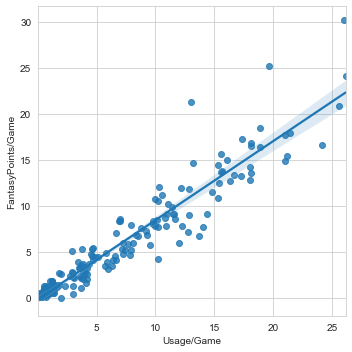

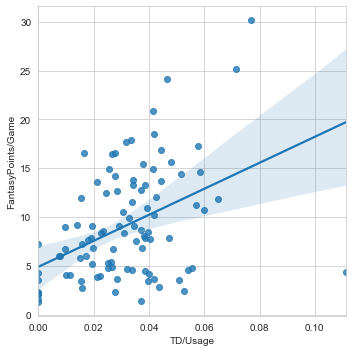

In [355]:
#just for styling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#basic regression scatter plot with trendline
plot = sns.regplot(
x=rb_df['Usage/Game'],
y=rb_df['FantasyPoints/Game'],
scatter=True,)

plt.tight_layout();
plt.savefig('../static/images/RB_usage_per_game', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)


#How does efficiency correlate to fantasy football performance?
rb_df['TD/Usage'] = (rb_df['Rush TD']+ rb_df['Rec TD'])/(rb_df['Rush Att'] + rb_df['Rec Tgt'])
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#Make sure there is an adequete sample size
rb_df = rb_df[rb_df['Rush Att'] > 20]
plot = sns.regplot(
x=rb_df['TD/Usage'],
y=rb_df['FantasyPoints/Game'],
scatter=True)

plt.tight_layout();
plt.savefig('../static/images/RB_TD_per_usage', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [356]:
from sklearn.model_selection import train_test_split
X = rb_df['Usage'].values.reshape(-1, 1)
Y = rb_df['FantasyPoints'].values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [357]:
regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm
y_pred = regressor.predict(x_test)

In [358]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,52.9,63.537712
1,30.7,27.168796
2,116.6,77.589339
3,95.4,104.866026
4,218.5,203.227414


In [359]:
rb_df['FantasyPointPrediction'] = regressor.predict(X) # create a new column for usage

In [362]:
rb_df_with_headshots = rb_df.merge(roster_df, left_on='Player', right_on='full_name', how='left')
rb_df_with_headshots = rb_df_with_headshots.sort_values(by='UsageRank')   

#reset the index to a range index 0 -> length
rb_df_with_headshots = rb_df_with_headshots.reset_index(drop=True)

rb_df_with_headshots.head(10) 

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,Pass Int,Rush Att,Rush Yds,Rush Y/A,Rush TD,Rec Tgt,Receptions,Rec Yds,Rec Y/R,Rec TD,Fumbles Lost,Total TD,PPR,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank,TD/Usage,FantasyPointPrediction,full_name,headshot_url
0,2020,Derrick Henry,TEN,RB,26,16,0,0,0,0,0,378,2027,5.36,17,31,19,114,6.00,0,2,17,333.1,333.1,20.82,25.56,409,1.0,3.0,0.041565,335.478019,Derrick Henry,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,2020,Dalvin Cook,MIN,RB,25,14,0,0,0,0,0,312,1557,4.99,16,54,44,361,8.20,1,3,17,337.8,337.8,24.13,26.14,366,2.0,2.0,0.046448,299.935669,Dalvin Cook,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,2020,Josh Jacobs,LVR,RB,22,15,0,0,0,0,0,273,1065,3.90,12,45,33,238,7.21,0,2,12,231.3,231.3,15.42,21.20,318,3.0,8.0,0.037736,260.260487,Josh Jacobs,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,2020,David Montgomery,CHI,RB,23,15,0,0,0,0,0,247,1070,4.33,8,68,54,438,8.11,2,1,10,264.8,264.8,17.65,21.00,315,4.5,4.0,0.031746,257.780788,David Montgomery,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,2020,Ezekiel Elliott,DAL,RB,25,15,0,0,0,0,0,244,979,4.01,6,71,52,338,6.50,2,5,8,223.7,223.7,14.91,21.00,315,4.5,9.0,0.025397,257.780788,Ezekiel Elliott,https://a.espncdn.com/combiner/i?img=/i/headsh...
5,2020,James Robinson,JAX,RB,22,14,0,0,0,0,0,240,1070,4.46,7,60,49,344,7.02,3,1,10,250.4,250.4,17.89,21.43,300,6.0,7.0,0.033333,245.382294,James Robinson,https://a.espncdn.com/combiner/i?img=/i/headsh...
6,2020,Alvin Kamara,NOR,RB,25,15,0,0,0,0,0,187,932,4.98,16,107,83,756,9.11,5,0,21,377.8,377.8,25.19,19.60,294,7.0,1.0,0.071429,240.422897,Alvin Kamara,https://a.espncdn.com/combiner/i?img=/i/headsh...
7,2020,Jonathan Taylor,IND,RB,21,15,0,0,0,0,0,232,1169,5.04,11,39,36,299,8.31,1,1,12,252.8,252.8,16.85,18.07,271,8.0,6.0,0.044280,221.411872,Jonathan Taylor,https://a.espncdn.com/combiner/i?img=/i/headsh...
8,2020,Kenyan Drake,ARI,RB,26,15,0,0,0,0,0,239,955,4.00,10,31,25,137,5.48,0,1,10,192.2,192.2,12.81,18.00,270,9.0,16.0,0.037037,220.585306,Kenyan Drake,https://a.espncdn.com/combiner/i?img=/i/headsh...
9,2020,Aaron Jones,GNB,RB,26,14,0,0,0,0,0,201,1104,5.49,9,63,47,355,7.55,2,0,11,258.9,258.9,18.49,18.86,264,10.0,5.0,0.041667,215.625908,Aaron Jones,https://a.espncdn.com/combiner/i?img=/i/headsh...


# WR: Compare usage vs efficiency

In [367]:
#Create new column for usage per game. Usage is defined as # of targets + carries
wr_df['Usage/Game'] = (wr_df['Rush Att'] + wr_df['Rec Tgt'])/wr_df['Games Played']

#round each row value to two decimal places
wr_df['Usage/Game'] = wr_df['Usage/Game'].apply(lambda x: round(x, 2))

wr_df['Usage'] = wr_df['Rec Tgt'] + wr_df['Rush Att'] # create a new column for usage
wr_df['UsageRank'] = wr_df['Usage'].rank(ascending=False)
wr_df['FantasyPointsRank'] = wr_df['FantasyPoints'].rank(ascending=False)

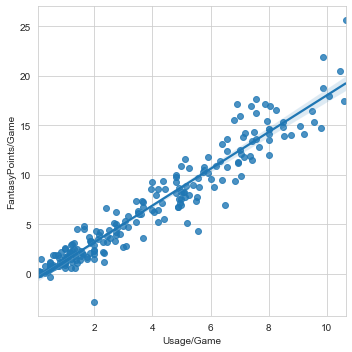

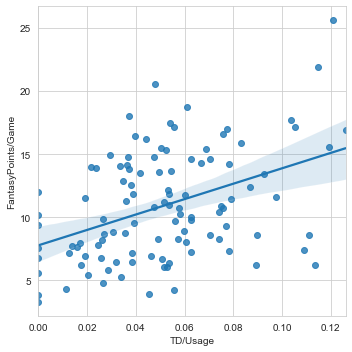

In [368]:
#just for styling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#basic regression scatter plot with trendline
plot = sns.regplot(
x=wr_df['Usage/Game'],
y=wr_df['FantasyPoints/Game'],
scatter=True,)

plt.tight_layout();
plt.savefig('../static/images/WR_usage_per_game', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)



#How does efficiency correlate to fantasy football performance?
wr_df['TD/Usage'] = (wr_df['Rush TD']+ wr_df['Rec TD'])/(wr_df['Rush Att'] + wr_df['Rec Tgt'])
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#Make sure there is an adequete sample size
wr_df = wr_df[wr_df['Receptions'] > 20]
plot = sns.regplot(
x=wr_df['TD/Usage'],
y=wr_df['FantasyPoints/Game'],
scatter=True)

plt.tight_layout();
plt.savefig('../static/images/WR_TD_per_usage', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [369]:
from sklearn.model_selection import train_test_split
X = wr_df['Usage'].values.reshape(-1, 1)
Y = wr_df['FantasyPoints'].values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm
y_pred = regressor.predict(x_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,191.0,146.796340
1,87.4,95.706200
2,223.8,241.678028
3,247.5,186.938593
4,155.4,155.919579


In [370]:
wr_df['FantasyPointPrediction'] = regressor.predict(X) # create a new column for usage

In [371]:
wr_df_with_headshots = wr_df.merge(roster_df, left_on='Player', right_on='full_name', how='left')
wr_df_with_headshots = wr_df_with_headshots.sort_values(by='UsageRank')  

#reset the index to a range index 0 -> length
wr_df_with_headshots = wr_df_with_headshots.reset_index(drop=True)

wr_df_with_headshots.head(10)  

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,Pass Int,Rush Att,Rush Yds,Rush Y/A,Rush TD,Rec Tgt,Receptions,Rec Yds,Rec Y/R,Rec TD,Fumbles Lost,Total TD,PPR,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank,TD/Usage,FantasyPointPrediction,full_name,headshot_url
0,2020,Stefon Diggs,BUF,WR,27,16,0,0,0,0,0,1,1,1.00,0,166,127,1535,12.09,8,0,8,328.6,328.6,20.54,10.44,167,1.0,3.0,0.047904,298.242112,Stefon Diggs,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,2020,DeAndre Hopkins,ARI,WR,28,16,0,0,0,0,0,1,1,1.00,0,160,115,1407,12.23,6,2,6,287.8,287.8,17.99,10.06,161,2.0,4.0,0.037267,287.294225,DeAndre Hopkins,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,2020,Robert Woods,LAR,WR,28,16,0,0,0,0,0,24,155,6.46,2,129,90,936,10.40,6,1,8,245.1,245.1,15.32,9.56,153,3.0,13.5,0.052288,272.697042,Robert Woods,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,2020,Allen Robinson,CHI,WR,27,16,0,0,0,0,0,1,-1,-1.00,0,151,102,1250,12.25,6,0,6,262.9,262.9,16.43,9.50,152,4.0,9.0,0.039474,270.872394,Allen Robinson,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,2020,Davante Adams,GNB,WR,28,14,0,0,0,0,0,0,0,0.00,0,149,115,1374,11.95,18,1,18,358.4,358.4,25.60,10.64,149,5.0,1.0,0.120805,265.398450,Davante Adams,https://a.espncdn.com/combiner/i?img=/i/headsh...
5,2020,Keenan Allen,LAC,WR,28,14,0,1,0,0,0,1,-1,-1.00,0,147,100,992,9.92,8,2,8,245.1,245.1,17.51,10.57,148,7.0,13.5,0.054054,263.573803,Keenan Allen,https://a.espncdn.com/combiner/i?img=/i/headsh...
6,2020,Tyreek Hill,KAN,WR,26,15,0,0,0,0,0,13,123,9.46,2,135,87,1276,14.67,15,0,17,328.9,328.9,21.93,9.87,148,7.0,2.0,0.114865,263.573803,Tyreek Hill,https://a.espncdn.com/combiner/i?img=/i/headsh...
7,2020,Calvin Ridley,ATL,WR,26,15,0,0,0,0,0,5,1,0.20,0,143,90,1374,15.27,9,1,9,281.5,281.5,18.77,9.87,148,7.0,5.0,0.060811,263.573803,Calvin Ridley,https://a.espncdn.com/combiner/i?img=/i/headsh...
8,2020,Diontae Johnson,PIT,WR,24,15,0,0,0,0,0,3,15,5.00,0,144,88,923,10.49,7,1,7,221.8,221.8,14.79,9.80,147,9.0,21.0,0.047619,261.749155,Diontae Johnson,https://a.espncdn.com/combiner/i?img=/i/headsh...
9,2020,Robby Anderson,CAR,WR,27,16,0,0,0,0,0,4,15,3.75,0,136,95,1096,11.54,3,1,3,224.1,224.1,14.01,8.75,140,10.0,19.0,0.021429,248.976620,Robby Anderson,https://a.espncdn.com/combiner/i?img=/i/headsh...


# TE: Compare usage vs efficiency


In [372]:
#Create new column for usage per game. Usage is defined as # of targets + carries
te_df['Usage/Game'] = (te_df['Rush Att'] + te_df['Rec Tgt'])/te_df['Games Played']

#round each row value to two decimal places
te_df['Usage/Game'] = te_df['Usage/Game'].apply(lambda x: round(x, 2))

te_df['Usage'] = te_df['Rec Tgt'] + te_df['Rush Att'] # create a new column for usage
te_df['UsageRank'] = te_df['Usage'].rank(ascending=False)
te_df['FantasyPointsRank'] = te_df['FantasyPoints'].rank(ascending=False)

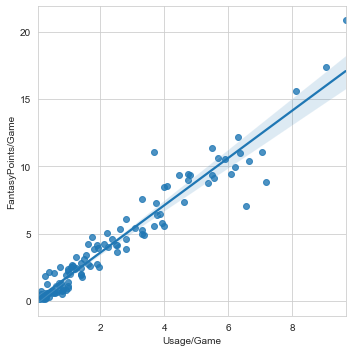

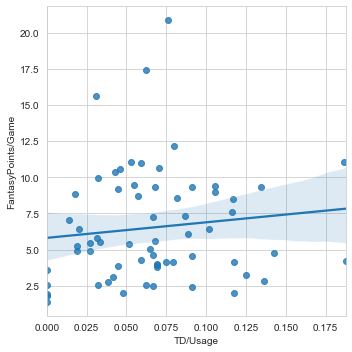

In [373]:
#just for styling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#basic regression scatter plot with trendline
plot = sns.regplot(
x=te_df['Usage/Game'],
y=te_df['FantasyPoints/Game'],
scatter=True,)

plt.tight_layout();
plt.savefig('../static/images/TE_usage_per_game', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)



#How does efficiency correlate to fantasy football performance?
te_df['TD/Usage'] = (te_df['Rush TD']+ te_df['Rec TD'])/(te_df['Rush Att'] + te_df['Rec Tgt'])
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#Make sure there is an adequete sample size
te_df = te_df[te_df['Receptions'] > 10]
plot = sns.regplot(
x=te_df['TD/Usage'],
y=te_df['FantasyPoints/Game'],
scatter=True)

plt.tight_layout();
plt.savefig('../static/images/TE_TD_per_usage', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [374]:
from sklearn.model_selection import train_test_split
X = te_df['Usage'].values.reshape(-1, 1)
Y = te_df['FantasyPoints'].values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm
y_pred = regressor.predict(x_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,41.9,29.244921
1,40.5,56.521548
2,145.3,169.264941
3,141.0,209.270661
4,24.9,36.518688


In [375]:
te_df['FantasyPointPrediction'] = regressor.predict(X) # create a new column for usage

In [378]:
te_df_with_headshots = te_df.merge(roster_df, left_on='Player', right_on='full_name', how='left')
te_df_with_headshots = te_df_with_headshots.sort_values(by='UsageRank') 

#reset the index to a range index 0 -> length
te_df_with_headshots = te_df_with_headshots.reset_index(drop=True)

te_df_with_headshots.head(10) 

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,Pass Int,Rush Att,Rush Yds,Rush Y/A,Rush TD,Rec Tgt,Receptions,Rec Yds,Rec Y/R,Rec TD,Fumbles Lost,Total TD,PPR,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank,TD/Usage,FantasyPointPrediction,full_name,headshot_url
0,2020,Travis Kelce,KAN,TE,31,15,1,2,4,0,0,0,0,0.00,0,145,105,1416,13.49,11,1,11,312.8,312.8,20.85,9.67,145,1.5,1.0,0.075862,263.823916,Travis Kelce,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,2020,Darren Waller,LVR,TE,28,16,0,0,0,0,0,0,0,0.00,0,145,107,1196,11.18,9,2,9,278.6,278.6,17.41,9.06,145,1.5,2.0,0.062069,263.823916,Darren Waller,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,2020,Evan Engram,NYG,TE,26,16,0,0,0,0,0,6,26,4.33,1,109,63,654,10.38,1,1,2,141.0,141.0,8.81,7.19,115,3.0,15.0,0.017391,209.270661,Evan Engram,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,2020,Logan Thomas,WAS,TE,29,16,1,1,28,0,0,3,5,1.67,0,110,72,670,9.31,6,0,6,176.6,176.6,11.04,7.06,113,4.0,3.5,0.053097,205.633777,Logan Thomas,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,2020,T.J. Hockenson,DET,TE,23,16,0,0,0,0,0,1,0,0.00,0,101,67,723,10.79,6,1,6,175.3,175.3,10.96,6.38,102,5.0,5.0,0.058824,185.630917,T.J. Hockenson,https://a.espncdn.com/combiner/i?img=/i/headsh...
5,2020,Noah Fant,DEN,TE,23,15,0,0,0,0,0,0,0,0.00,0,93,62,673,10.85,3,0,3,149.3,149.3,9.95,6.20,93,6.5,8.5,0.032258,169.264941,Noah Fant,https://a.espncdn.com/combiner/i?img=/i/headsh...
6,2020,Hunter Henry,LAC,TE,26,14,0,0,0,0,0,0,0,0.00,0,93,60,613,10.22,4,0,4,145.3,145.3,10.38,6.64,93,6.5,12.0,0.043011,169.264941,Hunter Henry,https://a.espncdn.com/combiner/i?img=/i/headsh...
7,2020,Eric Ebron,PIT,TE,27,15,0,0,0,0,0,0,0,0.00,0,91,56,558,9.96,5,1,5,141.8,141.8,9.45,6.07,91,8.0,14.0,0.054945,165.628057,Eric Ebron,https://a.espncdn.com/combiner/i?img=/i/headsh...
8,2020,Dalton Schultz,DAL,TE,24,16,0,0,0,0,0,0,0,0.00,0,89,63,615,9.76,4,1,4,146.5,146.5,9.16,5.56,89,9.0,11.0,0.044944,161.991174,Dalton Schultz,https://a.espncdn.com/combiner/i?img=/i/headsh...
9,2020,Hayden Hurst,ATL,TE,27,16,0,0,0,0,0,0,0,0.00,0,88,56,571,10.20,6,0,6,149.1,149.1,9.32,5.50,88,10.5,10.0,0.068182,160.172732,Hayden Hurst,https://a.espncdn.com/combiner/i?img=/i/headsh...


# QB: Compare usage vs efficiency


In [390]:
yearly_stats_all_pos_df.columns

Index(['Season', 'Player', 'Team', 'Pos', 'Age', 'Games Played', 'Pass Comp',
       'Pass Att', 'Pass Yds', 'Pass TD', 'Pass Int', 'Rush Att', 'Rush Yds',
       'Rush Y/A', 'Rush TD', 'Rec Tgt', 'Receptions', 'Rec Yds', 'Rec Y/R',
       'Rec TD', 'Fumbles Lost', 'Total TD', 'PPR', 'FantasyPoints',
       'FantasyPoints/Game'],
      dtype='object')

In [391]:
#Create new column for usage per game. Usage is defined as # of targets + carries
qb_df['Usage/Game'] = (qb_df['Pass Att'] + qb_df['Rush Att'])/qb_df['Games Played']

#round each row value to two decimal places
qb_df['Usage/Game'] = qb_df['Usage/Game'].apply(lambda x: round(x, 2))

qb_df['Usage'] = qb_df['Pass Att'] + qb_df['Rush Att'] # create a new column for usage
qb_df['UsageRank'] = qb_df['Usage'].rank(ascending=False)
qb_df['FantasyPointsRank'] = qb_df['FantasyPoints'].rank(ascending=False)

In [392]:
qb_df

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,Pass Int,Rush Att,Rush Yds,Rush Y/A,Rush TD,Rec Tgt,Receptions,Rec Yds,Rec Y/R,Rec TD,Fumbles Lost,Total TD,PPR,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank,TD/Usage,FantasyPointPrediction
25,2020,A.J. McCarron,HOU,QB,30,2,1,1,20,0,0,0,0,0.00,0,0,0,0,0.0,0,0,0,0.8,0.8,0.40,0.50,1,83.0,77.0,0.000000,-10.673193
69,2020,Aaron Rodgers,GNB,QB,37,16,372,526,4299,48,5,38,149,3.92,3,1,1,-6,-6.0,0,2,3,383.3,383.3,23.96,35.25,564,11.0,2.0,0.090426,281.245560
232,2020,Alex Smith,WAS,QB,36,8,168,252,1582,6,8,10,3,0.30,0,0,0,0,0.0,0,0,0,71.6,71.6,8.95,32.75,262,34.0,37.0,0.022901,124.656815
418,2020,Andy Dalton,DAL,QB,33,11,216,333,2170,14,8,28,114,4.07,0,1,1,-3,-3.0,0,1,0,136.9,136.9,12.45,32.82,361,27.0,30.0,0.038781,175.988887
685,2020,Baker Mayfield,CLE,QB,25,16,305,486,3563,26,8,54,165,3.06,1,1,1,6,6.0,0,4,1,248.6,248.6,15.54,33.75,540,17.0,17.0,0.050000,268.801421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9256,2020,Trace McSorley,BAL,QB,25,2,3,10,90,1,0,5,17,3.40,0,0,0,0,0.0,0,0,0,9.3,9.3,4.65,7.50,15,68.5,60.5,0.066667,-3.414112
9411,2020,Tua Tagovailoa,MIA,QB,22,10,186,290,1814,11,5,36,109,3.03,3,0,0,0,0.0,0,1,3,135.5,135.5,13.55,32.60,326,32.0,32.0,0.042945,157.841185
9426,2020,Tyler Bray,CHI,QB,29,1,1,5,18,0,0,0,0,0.00,0,0,0,0,0.0,0,0,0,0.7,0.7,0.70,5.00,5,78.0,78.0,0.000000,-8.599170
9453,2020,Tyler Huntley,BAL,QB,22,2,3,5,15,0,0,10,23,2.30,0,0,0,0,0.0,0,0,0,2.9,2.9,1.45,7.50,15,68.5,66.0,0.000000,-3.414112


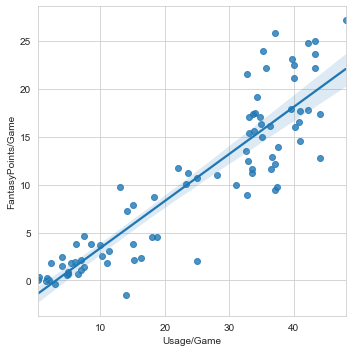

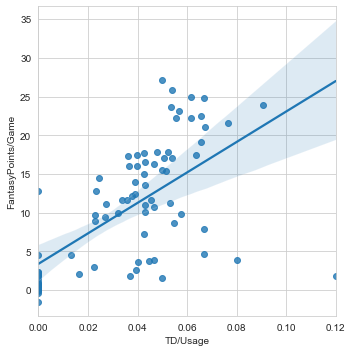

In [393]:
#just for styling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#basic regression scatter plot with trendline
plot = sns.regplot(
x=qb_df['Usage/Game'],
y=qb_df['FantasyPoints/Game'],
scatter=True,)

plt.tight_layout();
plt.savefig('../static/images/QB_usage_per_game', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)



#How does efficiency correlate to fantasy football performance?
qb_df['TD/Usage'] = (qb_df['Pass TD']+ qb_df['Rush TD'])/(qb_df['Pass Att'] + qb_df['Rush Att'])
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#Make sure there is an adequete sample size
#qb_df = qb_df[qb_df['Receptions'] > 10]
plot = sns.regplot(
x=qb_df['TD/Usage'],
y=qb_df['FantasyPoints/Game'],
scatter=True)

plt.tight_layout();
plt.savefig('../static/images/QB_TD_per_usage', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [394]:
from sklearn.model_selection import train_test_split
X = qb_df['Usage'].values.reshape(-1, 1)
Y = qb_df['FantasyPoints'].values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm
y_pred = regressor.predict(x_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,11.3,11.371064
1,14.5,9.335941
2,9.3,-3.892359
3,359.8,314.604402
4,135.6,110.583314


In [395]:
qb_df['FantasyPointPrediction'] = regressor.predict(X) # create a new column for usage

In [396]:
qb_df_with_headshots = qb_df.merge(roster_df, left_on='Player', right_on='full_name', how='left')
qb_df_with_headshots = qb_df_with_headshots.sort_values(by='UsageRank')   

#reset the index to a range index 0 -> length
qb_df_with_headshots = qb_df_with_headshots.reset_index(drop=True)

qb_df_with_headshots.head(10) 

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,Pass Int,Rush Att,Rush Yds,Rush Y/A,Rush TD,Rec Tgt,Receptions,Rec Yds,Rec Y/R,Rec TD,Fumbles Lost,Total TD,PPR,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank,TD/Usage,FantasyPointPrediction,full_name,headshot_url
0,2020,Kyler Murray,ARI,QB,23,16,375,558,3971,26,12,133,819,6.16,11,0,0,0,0.0,0,4,11,378.7,378.7,23.67,43.19,691,1.0,3.0,0.053546,340.043440,Kyler Murray,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,2020,Josh Allen,BUF,QB,24,16,396,572,4544,37,10,102,421,4.13,8,1,1,12,12.0,1,6,9,396.1,396.1,24.76,42.12,674,2.0,1.0,0.066766,331.394167,Josh Allen,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,2020,Matt Ryan,ATL,QB,35,16,407,626,4581,26,11,29,92,3.17,2,0,0,0,0.0,0,3,2,282.4,282.4,17.65,40.94,655,3.0,12.0,0.042748,321.727333,Matt Ryan,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,2020,Justin Herbert,LAC,QB,22,15,396,595,4336,31,10,55,234,4.25,5,0,0,0,0.0,0,1,5,332.8,332.8,22.19,43.33,650,4.5,9.5,0.055385,319.183429,Justin Herbert,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,2020,Patrick Mahomes,KAN,QB,25,15,390,588,4740,38,6,62,308,4.97,2,2,0,0,0.0,0,2,2,374.4,374.4,24.96,43.33,650,4.5,4.0,0.061538,319.183429,Patrick Mahomes,https://a.espncdn.com/combiner/i?img=/i/headsh...
5,2020,Russell Wilson,SEA,QB,32,16,384,558,4212,40,13,83,513,6.18,2,0,0,0,0.0,0,4,2,359.8,359.8,22.49,40.06,641,6.0,6.0,0.065523,314.604402,Russell Wilson,https://a.espncdn.com/combiner/i?img=/i/headsh...
6,2020,Tom Brady,TAM,QB,43,16,401,610,4633,40,12,30,6,0.20,3,0,0,0,0.0,0,1,3,337.9,337.9,21.12,40.00,640,7.0,8.0,0.067187,314.095621,Tom Brady,https://a.espncdn.com/combiner/i?img=/i/headsh...
7,2020,Deshaun Watson,HOU,QB,25,16,382,544,4823,33,7,90,444,4.93,3,0,0,0,0.0,0,3,3,369.3,369.3,23.08,39.62,634,8.0,5.0,0.056782,311.042937,Deshaun Watson,https://a.espncdn.com/combiner/i?img=/i/headsh...
8,2020,Ben Roethlisberger,PIT,QB,38,15,399,608,3803,33,10,25,11,0.44,0,0,0,0,0.0,0,1,0,267.2,267.2,17.81,42.20,633,9.0,14.0,0.052133,310.534156,Ben Roethlisberger,https://a.espncdn.com/combiner/i?img=/i/headsh...
9,2020,Jared Goff,LAR,QB,26,15,370,552,3952,20,13,51,99,1.94,4,0,0,0,0.0,0,4,4,240.0,240.0,16.00,40.20,603,10.0,19.5,0.039801,295.270733,Jared Goff,https://a.espncdn.com/combiner/i?img=/i/headsh...


# Add to MySQL

In [387]:
# Create Engine and Pass in MySQL Connection

# Remote MySQL DB Connection  
remote_engine = create_engine(f"mysql://{remote_db_user}:{remote_db_pwd}@{remote_db_endpoint}:{remote_db_port}")
#print(f"postgresql://{local_db_user}:{local_db_pwd}@{local_db_endpoint}:{local_db_port}")

# Create a local database engine connection
remote_conn = remote_engine.connect()

# Create remote database
try:
    remote_conn.execution_options(isolation_level="AUTOCOMMIT").execute(f"CREATE DATABASE {remote_db_name}")
except Exception as e:
    print(e)

# Connect to remote database
try:
    remote_engine = create_engine(f"mysql://{remote_db_user}:{remote_db_pwd}@{remote_db_endpoint}:{remote_db_port}/{remote_db_name}")
    remote_conn = remote_engine.connect()
except Exception as e:
    print(e)  
    
#confirm tables
remote_engine.table_names()

(pymysql.err.ProgrammingError) (1007, "Can't create database 'fantasy_project'; database exists")
[SQL: CREATE DATABASE fantasy_project]
(Background on this error at: http://sqlalche.me/e/13/f405)


['fantasy_stats',
 'qb_df_with_headshots',
 'rb_df_with_headshots',
 'super_bowl_stats',
 'te_df_with_headshots',
 'wr_df_with_headshots']

In [388]:
rb_df_with_headshots.to_sql(name='rb_df_with_headshots', if_exists='replace', con=remote_conn, index=False)
wr_df_with_headshots.to_sql(name='wr_df_with_headshots', if_exists='replace', con=remote_conn, index=False)
te_df_with_headshots.to_sql(name='te_df_with_headshots', if_exists='replace', con=remote_conn, index=False)
qb_df_with_headshots.to_sql(name='qb_df_with_headshots', if_exists='replace', con=remote_conn, index=False)

In [389]:
#confirm tables
remote_engine.table_names()

['fantasy_stats',
 'qb_df_with_headshots',
 'rb_df_with_headshots',
 'super_bowl_stats',
 'te_df_with_headshots',
 'wr_df_with_headshots']